In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import cartopy as ccrs
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
precipurlbymonth="http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/.extREALTIME/.rain/T/monthlyAverage/T/%28Jan%201979%29/%28Dec%202018%29/RANGE/X/%28130W%29/%28100W%29/RANGE/Y/25/50/RANGE/T/(days%20since%201960-01-01)streamgridunitconvert/dods"
precipds=xr.open_dataset(precipurlbymonth)
ninourl="http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES/%5BX/Y%5Daverage/zlev/removeGRID/T/%28Jan%201979%29/%28Dec%202018%29/RANGE/yearly-anomalies/T/(days%20since%201960-01-01)streamgridunitconvert/dods"
ninods=xr.open_dataset(ninourl)
precipdegreeurl="http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/.extREALTIME/.rain/T/monthlyAverage/T/%28Jan%201979%29/%28Dec%202018%29/RANGE/X/%28130W%29/%28100W%29/RANGE/Y/25/50/RANGE/X/1/boxAverage/Y/1/boxAverage/T/%28days%20since%201960-01-01%29streamgridunitconvert/dods"
precipdsdegree=xr.open_dataset(precipdegreeurl)
wind = xr.open_dataset("http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP-DOE/.Reanalysis-2/.Monthly/.pgb/.pgb/.ugrdprs/P/200/VALUE/X/220/240/RANGE/Y/27/40/RANGE/[X/Y]average/SOURCES/.NOAA/.NCEP-DOE/.Reanalysis-2/.Monthly/.pgb/.pgb/.ugrdprs/P/200/VALUE/X/210/240/RANGE/Y/45/60/RANGE/[X/Y]average/sub/P/removeGRID/T/(days%20since%201960-01-01)streamgridunitconvert/dods")
wind.load()
precipdsdegree.load()
precipds.load()
ninods.load()

<xarray.Dataset>
Dimensions:  (T: 480)
Coordinates:
  * T        (T) datetime64[ns] 1979-01-16T12:00:00 ... 2018-12-16T12:00:00
Data variables:
    sst      (T) float64 -0.1057 -0.1836 0.03708 0.1015 ... 0.9096 0.9275 0.8727
Attributes:
    Conventions:  IRIDL

In [3]:
precipanom=precipds.groupby('T.month') - precipds.groupby('T.month').mean('T')
Spn=(precipanom.rain*ninods.sst).groupby("T.month").mean("T")
Sn = ninods.sst.groupby('T.month').std('T')
Sp = precipanom.rain.groupby('T.month').std('T')
Cpn = Spn/Sn/Sp
windanom=wind.groupby("T.month")-wind.groupby("T.month").mean("T")
Swn=(windanom.ugrdprs*ninods.sst).groupby("T.month").mean("T")
Sw = windanom.ugrdprs.groupby('T.month').std('T')
Cwn=Swn/Sn/Sw
vn=ninods.sst.groupby('T.month').var('T')
vw=windanom.ugrdprs.groupby('T.month').var('T')
Spw=(windanom.ugrdprs*precipanom.rain).groupby("T.month").mean("T")
Cpw=Spw/Sw/Sp
Bpn=Spn/vn
Bpw=Spw/vw
precipanomdegree=precipdsdegree.groupby('T.month') - precipdsdegree.groupby('T.month').mean('T')
Spndegree=(precipanomdegree.rain*ninods.sst).groupby("T.month").mean("T")
Spdegree = precipanomdegree.rain.groupby('T.month').std('T')
Cpndegree = Spndegree/Sn/Spdegree
Spwdegree=(windanom.ugrdprs*precipanomdegree.rain).groupby("T.month").mean("T")
Cpwdegree=Spwdegree/Sw/Spdegree
Bpndegree=Spndegree/vn
Bpwdegree=Spwdegree/vw

/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [4]:
def getlonlat(resolution):
    if resolution=="half":
        lats = np.linspace(24.75,50.25, 52)
        lons= np.linspace(-130.25,-99.75,62)
    else:
        lats = np.linspace(25,50, 26)
        lons= np.linspace(-130,-100,31)
    lons, lats = np.meshgrid(lons, lats)
    return lons, lats


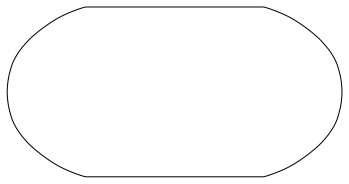

In [5]:
import cartopy.feature as cfeature
def plotmap(data,title,resolution="one",ax=plt.axes(projection=ccrs.crs.Robinson()),colorbar="auto"):
    central_lon, central_lat = -115, 40
    extent = [-130,-100,25, 50]
    ax.set_title(title)
    ax.set_extent(extent)
    ax.gridlines()
    ax.coastlines(resolution='50m')
    ax.add_feature(cfeature.STATES)
    lons, lats = getlonlat(resolution)
    cb=ax.contourf(lons, lats, data,transform=ccrs.crs.PlateCarree(),cmap='nipy_spectral')
    if colorbar=="auto":
        plt.colorbar(cb, cmap='nipy_spectral', orientation='vertical',ticklocation='auto')
    else:
        return cb
        

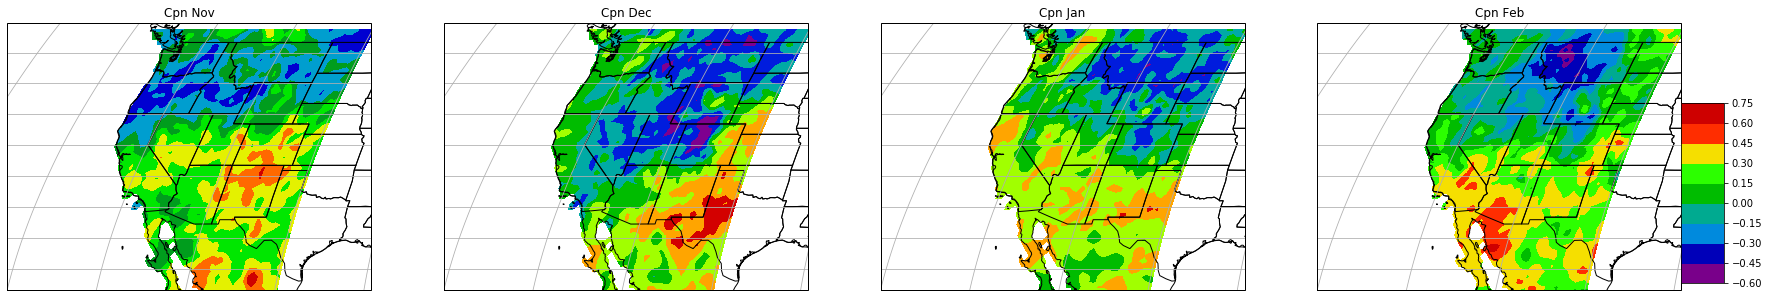

In [6]:
month=["Nov","Dec","Jan","Feb"]
monthnum=[10,11,0,1]
fig, (ax1, ax2,ax3,ax4) = plt.subplots(ncols=4, subplot_kw={'projection': ccrs.crs.Robinson()},figsize=(30,5))
for i,j in enumerate([ax1,ax2,ax3,ax4]):
    cb=plotmap(Cpn[monthnum[i]],"Cpn "+month[i],"half",ax=j,colorbar="nonauto")
cbar=fig.add_axes([.9, 0.15, 0.02, 0.5])
fig.colorbar(cb,cax=cbar)


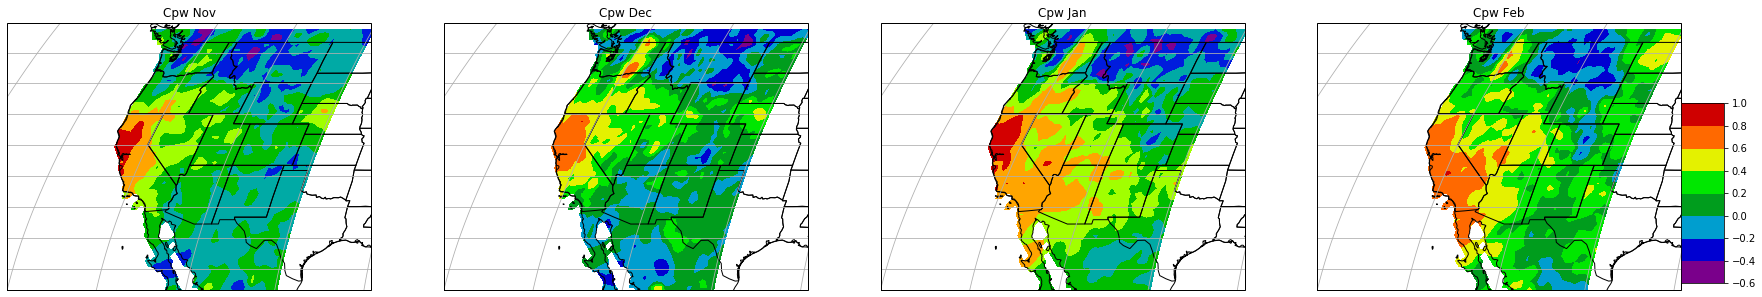

In [7]:
month=["Nov","Dec","Jan","Feb"]
monthnum=[10,11,0,1]
fig, (ax1, ax2,ax3,ax4) = plt.subplots(ncols=4, subplot_kw={'projection': ccrs.crs.Robinson()},figsize=(30,5))
for i,j in enumerate([ax1,ax2,ax3,ax4]):
    cb=plotmap(Cpw[monthnum[i]],"Cpw "+month[i],"half",ax=j,colorbar="nonauto")
cbar=fig.add_axes([.9, 0.15, 0.02, 0.5])
fig.colorbar(cb,cax=cbar)

Quick Single Variable Regression for checking:

In [8]:
vn=ninods.sst.groupby('T.month').var('T')
vw=windanom.ugrdprs.groupby('T.month').var('T')
Bpn=Spn/vn
Bpn_0=precipanom.rain.mean("T")-ninods.sst.groupby('T.month').mean("T")*Bpn
Bpw=Spw/vw
Bpw_0=precipanom.rain.mean("T")-wind.ugrdprs.groupby("T.month").mean("T")*Bpw

/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [9]:
def multiregression(month,shape=(52,62)):
    windmonth=wind.sel(T=wind["T.month"]==month)
    ninodsmonth=ninods.sel(T=ninods["T.month"]==month)
    sstvar=ninodsmonth.sst
    windvar=windmonth.ugrdprs-wind.ugrdprs.mean("T")
    precipdsmonth=precipds.sel(T=precipds['T.month']==month)
    rain=precipdsmonth.rain-precipds.rain.mean("T")
    cons=np.empty(shape)
    residual=np.empty(shape)
    correlation=np.empty((52,62,40))
    if shape==(52,62):
        x,y=getlonlat("half")
    else:
         x,y=getlonlat("one")
    windcoef=np.empty(shape)
    sstcoef=np.empty(shape)
    a_array=np.ones((40,3))
    a_array[:,0]=sstvar
    a_array[:,1]=windvar
    for i in range(shape[1]):
        for j in range(shape[0]):
            a_matrix=np.matmul(np.transpose(a_array),a_array)
            b_array=np.array(rain.sel(Y=y[j,i],X=x[j,i]))
            B=np.matmul(np.transpose(a_array),b_array)
            X=np.linalg.solve(a_matrix,B) 
            yhat=np.matmul(a_array,X)
            residual[j,i]=np.nansum(np.square(b_array-yhat))
            windcoef[j,i]=X[0]
            sstcoef[j,i]=X[1]
            cons[j,i]=X[2]
            correlation[j,i,:]=np.square(b_array-yhat)
    return windcoef,sstcoef,cons,correlation,residual
def singleregression(typeof,month,shape=(52,62)):
    windmonth=wind.sel(T=wind["T.month"]==month)
    ninodsmonth=ninods.sel(T=ninods["T.month"]==month)
    sstvar=ninodsmonth.sst
    windvar=windmonth.ugrdprs-wind.ugrdprs.mean("T")
    precipdsmonth=precipds.sel(T=precipds['T.month']==month)
    rain=precipdsmonth.rain-precipds.rain.mean("T")
    cons=np.empty(shape)
    residual=np.empty(shape)
    correlation=np.empty((52,62,40))
    if shape==(52,62):
        x,y=getlonlat("half")
    else:
         x,y=getlonlat("one")
    if typeof=="wind":
        coef=np.empty(shape)
        a_array=np.ones((40,2))
        a_array[:,0]=windvar
        for i in range(shape[1]):
            for j in range(shape[0]):
                a_matrix=np.matmul(np.transpose(a_array),a_array)
                b_array=np.array(rain.sel(Y=y[j,i],X=x[j,i]))
                B=np.matmul(np.transpose(a_array),b_array)
                X=np.linalg.solve(a_matrix,B) 
                yhat=np.matmul(a_array,X)
                residual[j,i]=np.nansum(np.square(b_array-yhat))
                coef[j,i]=X[0]
                cons[j,i]=X[1]
                correlation[j,i,:]=np.square(b_array-yhat)
    else:
        coef=np.empty(shape)
        a_array=np.ones((40,2))
        a_array[:,0]=sstvar
        for i in range(shape[1]):
            for j in range(shape[0]):
                a_matrix=np.matmul(np.transpose(a_array),a_array)
                b_array=np.array(rain.sel(Y=y[j,i],X=x[j,i]))
                B=np.matmul(np.transpose(a_array),b_array)
                X=np.linalg.solve(a_matrix,B) 
                yhat=np.matmul(a_array,X)
                residual[j,i]=np.nansum(np.square(b_array-yhat))
                coef[j,i]=X[0]
                cons[j,i]=X[1]
                correlation[j,i,:]=np.square(b_array-yhat)
    return coef,cons,correlation,residual
        
    
                

/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


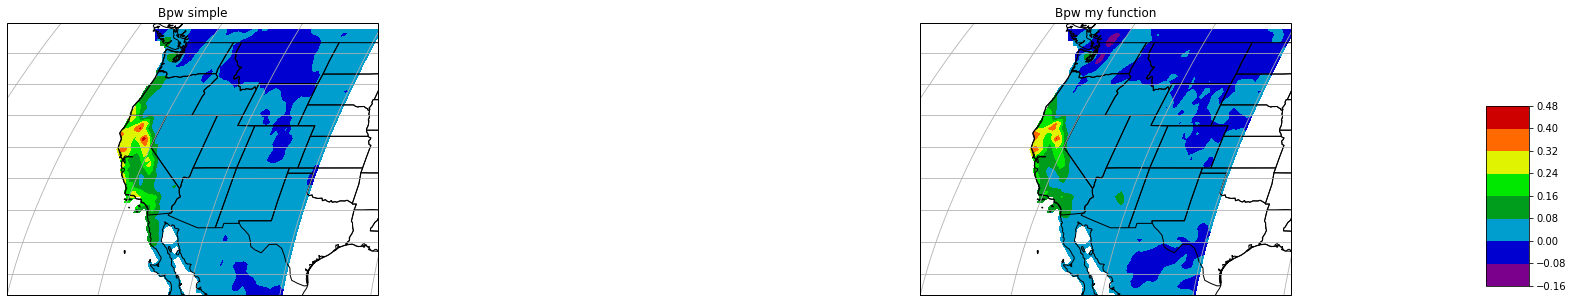

In [10]:
fig, (ax1,ax2) = plt.subplots(ncols=2, subplot_kw={'projection': ccrs.crs.Robinson()},figsize=(30,5))
if __name__ =="__main__":
    plotmap(Bpw[1],"Bpw simple","half",ax=ax1,colorbar="nonauto")
    cb=plotmap(singleregression("wind",1)[0],"Bpw my function","half",ax=ax2,colorbar="nonauto")
    cbar=fig.add_axes([.9, 0.15, 0.02, 0.5])
    fig.colorbar(cb,cax=cbar)

In [11]:
def ftest(month):
    monthnames={1:"Jan",2:"Feb",11:"Nov",12:"Dec"}
    bivar=multiregression(month)[4]
    wind=singleregression("wind",month)[3]
    sst=singleregression("sst",month)[3]
    fwind=np.divide((wind-bivar),bivar)*38
    fsst=np.divide((sst-bivar),bivar)*38
    return fsst,fwind

/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/brigidlynch/anaconda3/lib/pytho

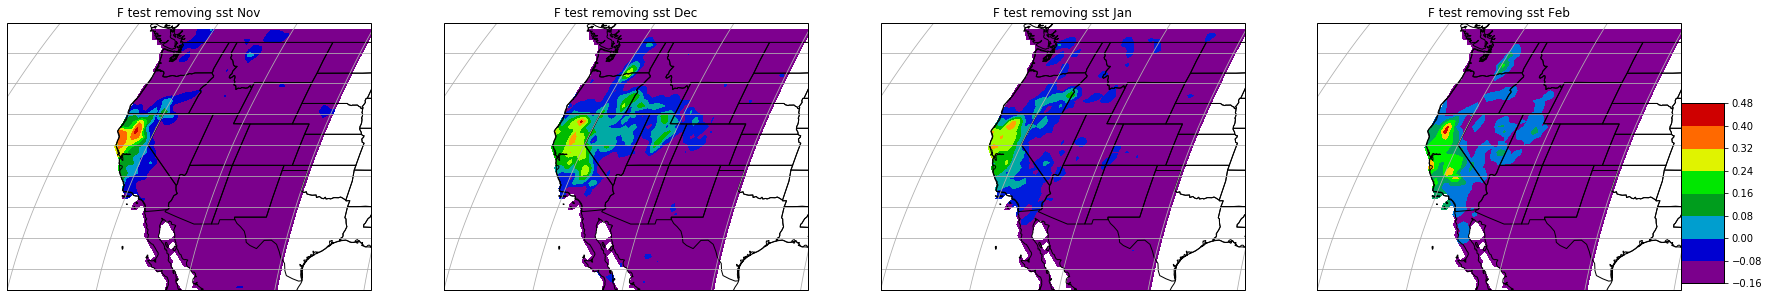

In [12]:
month=["Nov","Dec","Jan","Feb"]
monthnum=[11,12,1,2]
fig, (ax1, ax2,ax3,ax4) = plt.subplots(ncols=4,subplot_kw={'projection': ccrs.crs.Robinson()},figsize=(30,5))
axes=[ax1,ax2,ax3,ax4]
for i,j in enumerate(monthnum):
    plotmap(ftest(j)[0],"F test removing sst "+month[i],"half",ax=axes[i],colorbar="nonauto")
    cbar=fig.add_axes([.9, 0.15, 0.02, 0.5])
    fig.colorbar(cb,cax=cbar)





/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/brigidlynch/anaconda3/lib/pytho

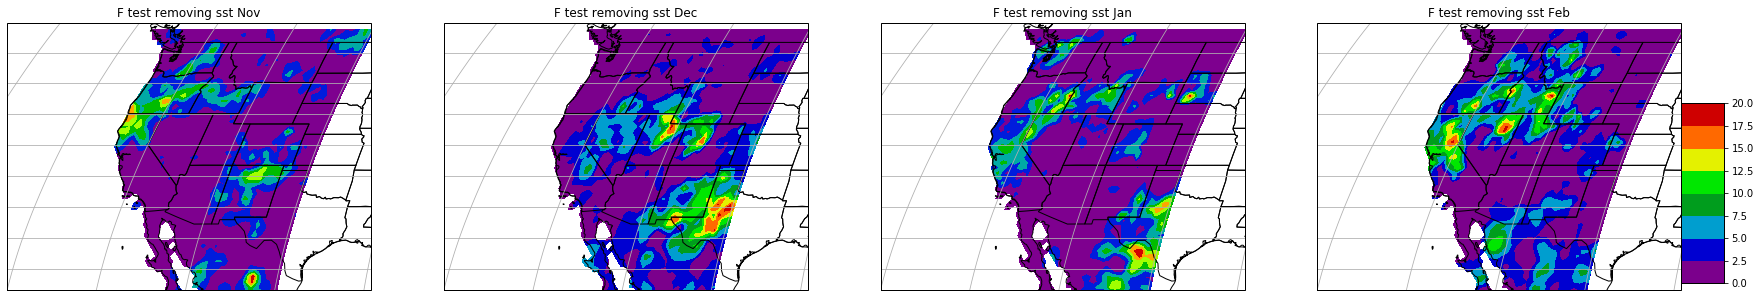

In [19]:
month=["Nov","Dec","Jan","Feb"]
monthnum=[11,12,1,2]
fig, (ax1, ax2,ax3,ax4) = plt.subplots(ncols=4,subplot_kw={'projection': ccrs.crs.Robinson()},figsize=(30,5))
axes=[ax1,ax2,ax3,ax4]
for i,j in enumerate(monthnum):
    cb=plotmap(ftest(j)[1],"F test removing sst "+month[i],"half",ax=axes[i],colorbar="nonauto")
    cbar=fig.add_axes([.9, 0.15, 0.02, 0.5])
    fig.colorbar(cb,cax=cbar)

Partial Correlations: 


In [14]:
from pydoc import help
from scipy.stats.stats import pearsonr
def partialcorrelation(month,shape=(52, 62)):
    mat1=singleregression("wind",month,shape)[2]
    mat2=singleregression("sst",month,shape)[2]
    residualcorrelation=np.zeros((52,62))
    for  i in range(52):
        for j in range(62):
            residualcorrelation[i,j]=pearsonr(mat1[i,j,:],mat2[i,j,:])[0]
    return residualcorrelation
print(partialcorrelation(1))

/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


[[       nan        nan        nan ... 0.99322464 0.98452291 0.98989646]
 [       nan        nan        nan ... 0.98011443 0.98357764 0.99117833]
 [       nan        nan        nan ... 0.99273488 0.99462214 0.99687433]
 ...
 [       nan        nan        nan ... 0.99985236 0.99606957 0.99650929]
 [       nan        nan        nan ... 0.99987761 0.99902135 0.99933869]
 [       nan        nan        nan ... 0.99795837 0.99845426 0.99426389]]


/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype

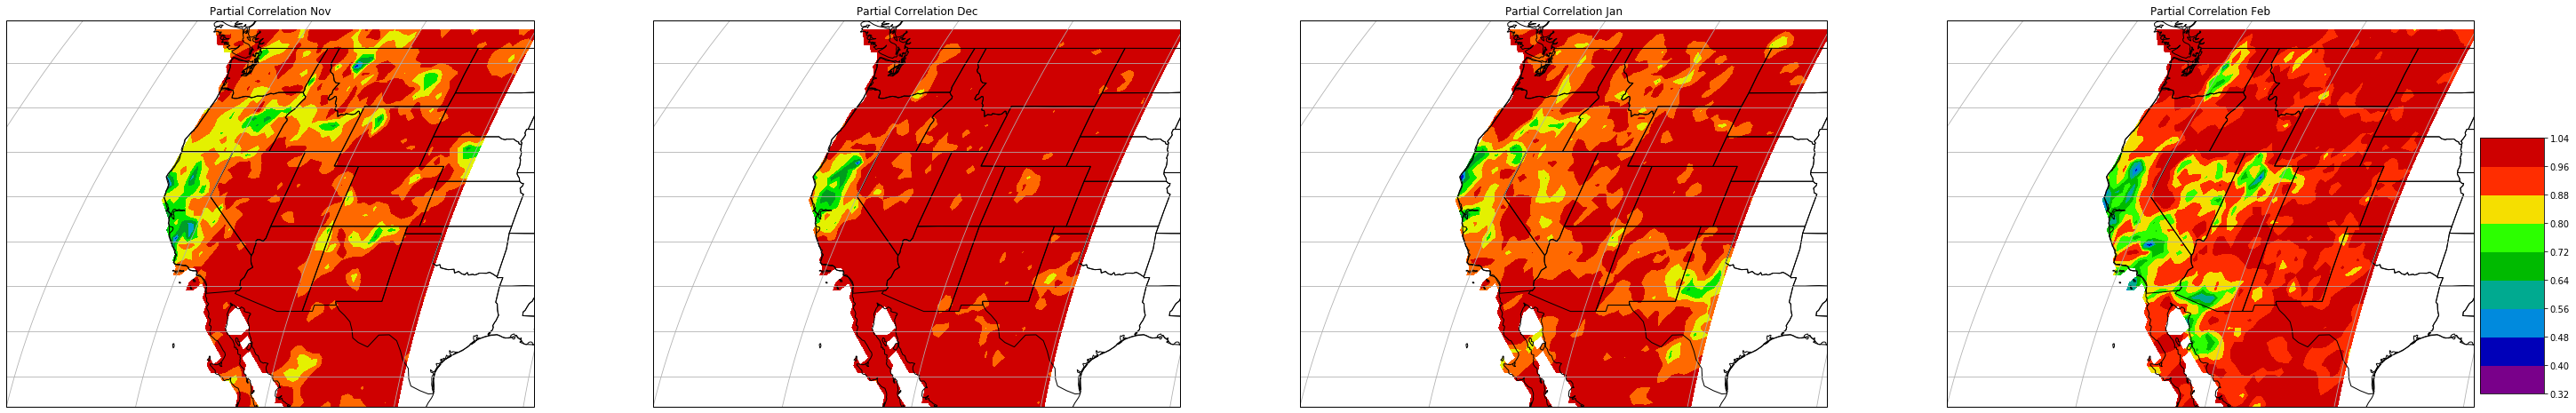

In [20]:
month=["Nov","Dec","Jan","Feb"]
monthnum=[11,12,1,2]
fig, (ax1, ax2,ax3,ax4) = plt.subplots(ncols=4,subplot_kw={'projection': ccrs.crs.Robinson()},figsize=(50,8))
axes=[ax1,ax2,ax3,ax4]
for i,j in enumerate(monthnum):
    cb=plotmap(partialcorrelation(j),"Partial Correlation "+month[i],"half",ax=axes[i],colorbar="notauto")
cbar=fig.add_axes([.9, 0.15, 0.02, 0.5])
fig.colorbar(cb,cax=cbar)

Confidence Intervals

In [16]:
def ci(typeof,month,shape=(52,62)):
    bound=(np.sqrt(singleregression(typeof,month,shape)[3]))*2.024
    upper=singleregression(typeof,month,shape)[0]+bound
    lower=singleregression(typeof,month,shape)[0]-bound
    signif=np.zeros((52,62))
    for i in range(52):
        for j in range(62):
            if (upper[i,j]>0 and lower[i,j]>0)or(upper[i,j]<0 and lower[i,j]<0):
                signif[i,j]=1
    return signif

In [17]:
np.mean(ci("sst",1))

/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/brigidlynch/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


0.0